In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1934360, 828)
(1934360, 8)
validation
(228776, 828)
(228776, 8)
test
(289081, 828)
(289081, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/194 [..............................] - ETA: 4:07 - loss: 2.3204 - STD: 0.1110 - MAE: 0.2179

  5/194 [..............................] - ETA: 3s - loss: 2.1334 - STD: 0.0648 - MAE: 0.2163  

  9/194 [>.............................] - ETA: 2s - loss: 2.1154 - STD: 0.0513 - MAE: 0.2169

 13/194 [=>............................] - ETA: 2s - loss: 2.0999 - STD: 0.0467 - MAE: 0.2168

 17/194 [=>............................] - ETA: 2s - loss: 2.0885 - STD: 0.0449 - MAE: 0.2167

 21/194 [==>...........................] - ETA: 2s - loss: 2.0822 - STD: 0.0430 - MAE: 0.2167

 25/194 [==>...........................] - ETA: 2s - loss: 2.0770 - STD: 0.0416 - MAE: 0.2166

 29/194 [===>..........................] - ETA: 2s - loss: 2.0722 - STD: 0.0406 - MAE: 0.2166

 33/194 [====>.........................] - ETA: 2s - loss: 2.0677 - STD: 0.0393 - MAE: 0.2166

 37/194 [====>.........................] - ETA: 2s - loss: 2.0626 - STD: 0.0385 - MAE: 0.2165

 41/194 [=====>........................] - ETA: 2s - loss: 2.0559 - STD: 0.0384 - MAE: 0.2162

 45/194 [=====>........................] - ETA: 2s - loss: 2.0473 - STD: 0.0388 - MAE: 0.2159

 49/194 [======>.......................] - ETA: 2s - loss: 2.0369 - STD: 0.0400 - MAE: 0.2155

 53/194 [=======>......................] - ETA: 2s - loss: 2.0259 - STD: 0.0419 - MAE: 0.2149

 57/194 [=======>......................] - ETA: 2s - loss: 2.0140 - STD: 0.0438 - MAE: 0.2143

 61/194 [========>.....................] - ETA: 2s - loss: 2.0018 - STD: 0.0459 - MAE: 0.2137

 65/194 [=========>....................] - ETA: 1s - loss: 1.9889 - STD: 0.0480 - MAE: 0.2130

 69/194 [=========>....................] - ETA: 1s - loss: 1.9752 - STD: 0.0503 - MAE: 0.2123

 73/194 [==========>...................] - ETA: 1s - loss: 1.9602 - STD: 0.0525 - MAE: 0.2115

 77/194 [==========>...................] - ETA: 1s - loss: 1.9446 - STD: 0.0548 - MAE: 0.2107

 81/194 [===========>..................] - ETA: 1s - loss: 1.9278 - STD: 0.0573 - MAE: 0.2098

 85/194 [============>.................] - ETA: 1s - loss: 1.9105 - STD: 0.0600 - MAE: 0.2087

 89/194 [============>.................] - ETA: 1s - loss: 1.8933 - STD: 0.0627 - MAE: 0.2077

 93/194 [=============>................] - ETA: 1s - loss: 1.8776 - STD: 0.0654 - MAE: 0.2067

 97/194 [==============>...............] - ETA: 1s - loss: 1.8618 - STD: 0.0681 - MAE: 0.2057

100/194 [==============>...............] - ETA: 1s - loss: 1.8505 - STD: 0.0700 - MAE: 0.2049

104/194 [===============>..............] - ETA: 1s - loss: 1.8360 - STD: 0.0725 - MAE: 0.2040

108/194 [===============>..............] - ETA: 1s - loss: 1.8222 - STD: 0.0748 - MAE: 0.2031

112/194 [================>.............] - ETA: 1s - loss: 1.8092 - STD: 0.0769 - MAE: 0.2022

116/194 [================>.............] - ETA: 1s - loss: 1.7967 - STD: 0.0790 - MAE: 0.2014

120/194 [=================>............] - ETA: 1s - loss: 1.7844 - STD: 0.0810 - MAE: 0.2006

124/194 [==================>...........] - ETA: 1s - loss: 1.7725 - STD: 0.0829 - MAE: 0.1998

128/194 [==================>...........] - ETA: 1s - loss: 1.7618 - STD: 0.0848 - MAE: 0.1991

132/194 [===================>..........] - ETA: 0s - loss: 1.7513 - STD: 0.0865 - MAE: 0.1984

136/194 [====================>.........] - ETA: 0s - loss: 1.7410 - STD: 0.0882 - MAE: 0.1976

140/194 [====================>.........] - ETA: 0s - loss: 1.7309 - STD: 0.0898 - MAE: 0.1969

144/194 [=====================>........] - ETA: 0s - loss: 1.7212 - STD: 0.0913 - MAE: 0.1963

148/194 [=====================>........] - ETA: 0s - loss: 1.7117 - STD: 0.0928 - MAE: 0.1956

152/194 [======================>.......] - ETA: 0s - loss: 1.7026 - STD: 0.0943 - MAE: 0.1950

156/194 [=======================>......] - ETA: 0s - loss: 1.6941 - STD: 0.0958 - MAE: 0.1943

160/194 [=======================>......] - ETA: 0s - loss: 1.6857 - STD: 0.0971 - MAE: 0.1937

164/194 [========================>.....] - ETA: 0s - loss: 1.6775 - STD: 0.0985 - MAE: 0.1931

168/194 [========================>.....] - ETA: 0s - loss: 1.6693 - STD: 0.0998 - MAE: 0.1925

172/194 [=========================>....] - ETA: 0s - loss: 1.6615 - STD: 0.1011 - MAE: 0.1919

176/194 [==========================>...] - ETA: 0s - loss: 1.6538 - STD: 0.1024 - MAE: 0.1913

180/194 [==========================>...] - ETA: 0s - loss: 1.6462 - STD: 0.1036 - MAE: 0.1908

182/194 [===========================>..] - ETA: 0s - loss: 1.6435 - STD: 0.1042 - MAE: 0.1905

185/194 [===========================>..] - ETA: 0s - loss: 1.6381 - STD: 0.1051 - MAE: 0.1900

188/194 [============================>.] - ETA: 0s - loss: 1.6326 - STD: 0.1060 - MAE: 0.1896

190/194 [============================>.] - ETA: 0s - loss: 1.6292 - STD: 0.1066 - MAE: 0.1894

194/194 [==============================] - ETA: 0s - loss: 1.6223 - STD: 0.1077 - MAE: 0.1888

194/194 [==============================] - 6s 24ms/step - loss: 1.6223 - STD: 0.1077 - MAE: 0.1888 - val_loss: 1.2584 - val_STD: 0.1590 - val_MAE: 0.1609


Epoch 2/10000


  1/194 [..............................] - ETA: 8s - loss: 1.2898 - STD: 0.1623 - MAE: 0.1625

  4/194 [..............................] - ETA: 3s - loss: 1.2936 - STD: 0.1627 - MAE: 0.1626

  7/194 [>.............................] - ETA: 3s - loss: 1.2904 - STD: 0.1635 - MAE: 0.1623

 11/194 [>.............................] - ETA: 2s - loss: 1.2859 - STD: 0.1639 - MAE: 0.1619

 15/194 [=>............................] - ETA: 2s - loss: 1.2808 - STD: 0.1643 - MAE: 0.1615

 19/194 [=>............................] - ETA: 2s - loss: 1.2783 - STD: 0.1649 - MAE: 0.1612

 23/194 [==>...........................] - ETA: 2s - loss: 1.2751 - STD: 0.1655 - MAE: 0.1608

 27/194 [===>..........................] - ETA: 2s - loss: 1.2717 - STD: 0.1661 - MAE: 0.1605

 31/194 [===>..........................] - ETA: 2s - loss: 1.2691 - STD: 0.1666 - MAE: 0.1602

 35/194 [====>.........................] - ETA: 2s - loss: 1.2683 - STD: 0.1671 - MAE: 0.1600

 39/194 [=====>........................] - ETA: 2s - loss: 1.2665 - STD: 0.1677 - MAE: 0.1597

 43/194 [=====>........................] - ETA: 2s - loss: 1.2634 - STD: 0.1681 - MAE: 0.1594

 47/194 [======>.......................] - ETA: 2s - loss: 1.2607 - STD: 0.1685 - MAE: 0.1591

 51/194 [======>.......................] - ETA: 2s - loss: 1.2585 - STD: 0.1689 - MAE: 0.1589

 55/194 [=======>......................] - ETA: 2s - loss: 1.2556 - STD: 0.1693 - MAE: 0.1586

 59/194 [========>.....................] - ETA: 2s - loss: 1.2529 - STD: 0.1696 - MAE: 0.1584

 63/194 [========>.....................] - ETA: 2s - loss: 1.2505 - STD: 0.1700 - MAE: 0.1581

 67/194 [=========>....................] - ETA: 1s - loss: 1.2489 - STD: 0.1704 - MAE: 0.1579

 71/194 [=========>....................] - ETA: 1s - loss: 1.2477 - STD: 0.1708 - MAE: 0.1577

 75/194 [==========>...................] - ETA: 1s - loss: 1.2459 - STD: 0.1711 - MAE: 0.1575

 78/194 [===========>..................] - ETA: 1s - loss: 1.2444 - STD: 0.1714 - MAE: 0.1573

 82/194 [===========>..................] - ETA: 1s - loss: 1.2423 - STD: 0.1717 - MAE: 0.1571

 86/194 [============>.................] - ETA: 1s - loss: 1.2409 - STD: 0.1721 - MAE: 0.1569

 90/194 [============>.................] - ETA: 1s - loss: 1.2408 - STD: 0.1724 - MAE: 0.1568

 94/194 [=============>................] - ETA: 1s - loss: 1.2402 - STD: 0.1727 - MAE: 0.1567

 98/194 [==============>...............] - ETA: 1s - loss: 1.2387 - STD: 0.1730 - MAE: 0.1565

102/194 [==============>...............] - ETA: 1s - loss: 1.2370 - STD: 0.1733 - MAE: 0.1563

106/194 [===============>..............] - ETA: 1s - loss: 1.2349 - STD: 0.1735 - MAE: 0.1561

110/194 [================>.............] - ETA: 1s - loss: 1.2334 - STD: 0.1738 - MAE: 0.1559

114/194 [================>.............] - ETA: 1s - loss: 1.2316 - STD: 0.1740 - MAE: 0.1558

118/194 [=================>............] - ETA: 1s - loss: 1.2298 - STD: 0.1743 - MAE: 0.1556

122/194 [=================>............] - ETA: 1s - loss: 1.2279 - STD: 0.1745 - MAE: 0.1554

125/194 [==================>...........] - ETA: 1s - loss: 1.2265 - STD: 0.1747 - MAE: 0.1553

129/194 [==================>...........] - ETA: 1s - loss: 1.2246 - STD: 0.1750 - MAE: 0.1551

133/194 [===================>..........] - ETA: 0s - loss: 1.2229 - STD: 0.1752 - MAE: 0.1549

137/194 [====================>.........] - ETA: 0s - loss: 1.2212 - STD: 0.1754 - MAE: 0.1547

141/194 [====================>.........] - ETA: 0s - loss: 1.2199 - STD: 0.1757 - MAE: 0.1546

145/194 [=====================>........] - ETA: 0s - loss: 1.2186 - STD: 0.1759 - MAE: 0.1544

148/194 [=====================>........] - ETA: 0s - loss: 1.2177 - STD: 0.1761 - MAE: 0.1543

152/194 [======================>.......] - ETA: 0s - loss: 1.2164 - STD: 0.1764 - MAE: 0.1542

156/194 [=======================>......] - ETA: 0s - loss: 1.2149 - STD: 0.1766 - MAE: 0.1540

160/194 [=======================>......] - ETA: 0s - loss: 1.2135 - STD: 0.1768 - MAE: 0.1539

164/194 [========================>.....] - ETA: 0s - loss: 1.2119 - STD: 0.1770 - MAE: 0.1537

168/194 [========================>.....] - ETA: 0s - loss: 1.2105 - STD: 0.1772 - MAE: 0.1536

172/194 [=========================>....] - ETA: 0s - loss: 1.2090 - STD: 0.1774 - MAE: 0.1534

175/194 [==========================>...] - ETA: 0s - loss: 1.2081 - STD: 0.1776 - MAE: 0.1533

179/194 [==========================>...] - ETA: 0s - loss: 1.2068 - STD: 0.1778 - MAE: 0.1532

183/194 [===========================>..] - ETA: 0s - loss: 1.2055 - STD: 0.1780 - MAE: 0.1531

186/194 [===========================>..] - ETA: 0s - loss: 1.2047 - STD: 0.1782 - MAE: 0.1530

189/194 [============================>.] - ETA: 0s - loss: 1.2036 - STD: 0.1783 - MAE: 0.1528

192/194 [============================>.] - ETA: 0s - loss: 1.2030 - STD: 0.1785 - MAE: 0.1528

194/194 [==============================] - 3s 18ms/step - loss: 1.2025 - STD: 0.1786 - MAE: 0.1527 - val_loss: 1.1618 - val_STD: 0.1910 - val_MAE: 0.1447


Epoch 3/10000


  1/194 [..............................] - ETA: 9s - loss: 1.1235 - STD: 0.1893 - MAE: 0.1448

  4/194 [..............................] - ETA: 3s - loss: 1.1354 - STD: 0.1886 - MAE: 0.1457

  7/194 [>.............................] - ETA: 3s - loss: 1.1345 - STD: 0.1883 - MAE: 0.1459

 11/194 [>.............................] - ETA: 3s - loss: 1.1337 - STD: 0.1883 - MAE: 0.1458

 14/194 [=>............................] - ETA: 3s - loss: 1.1331 - STD: 0.1886 - MAE: 0.1457

 17/194 [=>............................] - ETA: 3s - loss: 1.1318 - STD: 0.1887 - MAE: 0.1456

 21/194 [==>...........................] - ETA: 2s - loss: 1.1325 - STD: 0.1889 - MAE: 0.1455

 24/194 [==>...........................] - ETA: 2s - loss: 1.1309 - STD: 0.1890 - MAE: 0.1454

 27/194 [===>..........................] - ETA: 2s - loss: 1.1303 - STD: 0.1891 - MAE: 0.1454

 30/194 [===>..........................] - ETA: 2s - loss: 1.1290 - STD: 0.1892 - MAE: 0.1453

 33/194 [====>.........................] - ETA: 2s - loss: 1.1305 - STD: 0.1893 - MAE: 0.1453

 36/194 [====>.........................] - ETA: 2s - loss: 1.1300 - STD: 0.1895 - MAE: 0.1452

 39/194 [=====>........................] - ETA: 2s - loss: 1.1297 - STD: 0.1896 - MAE: 0.1451

 42/194 [=====>........................] - ETA: 2s - loss: 1.1291 - STD: 0.1898 - MAE: 0.1450

 45/194 [=====>........................] - ETA: 2s - loss: 1.1290 - STD: 0.1899 - MAE: 0.1450

 48/194 [======>.......................] - ETA: 2s - loss: 1.1295 - STD: 0.1900 - MAE: 0.1449

 51/194 [======>.......................] - ETA: 2s - loss: 1.1292 - STD: 0.1902 - MAE: 0.1449

 54/194 [=======>......................] - ETA: 2s - loss: 1.1293 - STD: 0.1903 - MAE: 0.1448

 58/194 [=======>......................] - ETA: 2s - loss: 1.1283 - STD: 0.1904 - MAE: 0.1447

 61/194 [========>.....................] - ETA: 2s - loss: 1.1286 - STD: 0.1905 - MAE: 0.1447

 64/194 [========>.....................] - ETA: 2s - loss: 1.1289 - STD: 0.1905 - MAE: 0.1448

 67/194 [=========>....................] - ETA: 2s - loss: 1.1284 - STD: 0.1906 - MAE: 0.1447

 70/194 [=========>....................] - ETA: 2s - loss: 1.1282 - STD: 0.1906 - MAE: 0.1447

 73/194 [==========>...................] - ETA: 2s - loss: 1.1280 - STD: 0.1907 - MAE: 0.1446

 77/194 [==========>...................] - ETA: 1s - loss: 1.1273 - STD: 0.1907 - MAE: 0.1446

 80/194 [===========>..................] - ETA: 1s - loss: 1.1265 - STD: 0.1908 - MAE: 0.1445

 83/194 [===========>..................] - ETA: 1s - loss: 1.1253 - STD: 0.1908 - MAE: 0.1444

 86/194 [============>.................] - ETA: 1s - loss: 1.1242 - STD: 0.1909 - MAE: 0.1444

 89/194 [============>.................] - ETA: 1s - loss: 1.1234 - STD: 0.1910 - MAE: 0.1443

 92/194 [=============>................] - ETA: 1s - loss: 1.1227 - STD: 0.1910 - MAE: 0.1442

 95/194 [=============>................] - ETA: 1s - loss: 1.1216 - STD: 0.1911 - MAE: 0.1442

 98/194 [==============>...............] - ETA: 1s - loss: 1.1206 - STD: 0.1912 - MAE: 0.1441

102/194 [==============>...............] - ETA: 1s - loss: 1.1190 - STD: 0.1913 - MAE: 0.1439

105/194 [===============>..............] - ETA: 1s - loss: 1.1182 - STD: 0.1914 - MAE: 0.1439

108/194 [===============>..............] - ETA: 1s - loss: 1.1175 - STD: 0.1915 - MAE: 0.1438

111/194 [================>.............] - ETA: 1s - loss: 1.1165 - STD: 0.1916 - MAE: 0.1437

115/194 [================>.............] - ETA: 1s - loss: 1.1151 - STD: 0.1917 - MAE: 0.1436

118/194 [=================>............] - ETA: 1s - loss: 1.1143 - STD: 0.1918 - MAE: 0.1435

121/194 [=================>............] - ETA: 1s - loss: 1.1132 - STD: 0.1919 - MAE: 0.1434

124/194 [==================>...........] - ETA: 1s - loss: 1.1129 - STD: 0.1921 - MAE: 0.1433

127/194 [==================>...........] - ETA: 1s - loss: 1.1134 - STD: 0.1922 - MAE: 0.1433

130/194 [===================>..........] - ETA: 1s - loss: 1.1130 - STD: 0.1923 - MAE: 0.1432

133/194 [===================>..........] - ETA: 1s - loss: 1.1126 - STD: 0.1924 - MAE: 0.1432

136/194 [====================>.........] - ETA: 0s - loss: 1.1122 - STD: 0.1925 - MAE: 0.1431

140/194 [====================>.........] - ETA: 0s - loss: 1.1115 - STD: 0.1926 - MAE: 0.1430

143/194 [=====================>........] - ETA: 0s - loss: 1.1107 - STD: 0.1927 - MAE: 0.1430

146/194 [=====================>........] - ETA: 0s - loss: 1.1102 - STD: 0.1928 - MAE: 0.1429

149/194 [======================>.......] - ETA: 0s - loss: 1.1093 - STD: 0.1928 - MAE: 0.1428

152/194 [======================>.......] - ETA: 0s - loss: 1.1086 - STD: 0.1929 - MAE: 0.1428

155/194 [======================>.......] - ETA: 0s - loss: 1.1078 - STD: 0.1930 - MAE: 0.1427

158/194 [=======================>......] - ETA: 0s - loss: 1.1068 - STD: 0.1931 - MAE: 0.1426

161/194 [=======================>......] - ETA: 0s - loss: 1.1061 - STD: 0.1931 - MAE: 0.1426

164/194 [========================>.....] - ETA: 0s - loss: 1.1054 - STD: 0.1932 - MAE: 0.1425

168/194 [========================>.....] - ETA: 0s - loss: 1.1042 - STD: 0.1933 - MAE: 0.1424

171/194 [=========================>....] - ETA: 0s - loss: 1.1033 - STD: 0.1934 - MAE: 0.1423

175/194 [==========================>...] - ETA: 0s - loss: 1.1021 - STD: 0.1935 - MAE: 0.1422

179/194 [==========================>...] - ETA: 0s - loss: 1.1009 - STD: 0.1937 - MAE: 0.1421

182/194 [===========================>..] - ETA: 0s - loss: 1.1000 - STD: 0.1938 - MAE: 0.1420

186/194 [===========================>..] - ETA: 0s - loss: 1.0994 - STD: 0.1939 - MAE: 0.1419

190/194 [============================>.] - ETA: 0s - loss: 1.0985 - STD: 0.1940 - MAE: 0.1418

194/194 [==============================] - ETA: 0s - loss: 1.0974 - STD: 0.1941 - MAE: 0.1417

194/194 [==============================] - 4s 19ms/step - loss: 1.0974 - STD: 0.1941 - MAE: 0.1417 - val_loss: 1.1059 - val_STD: 0.2017 - val_MAE: 0.1375


Epoch 4/10000


  1/194 [..............................] - ETA: 8s - loss: 1.0618 - STD: 0.1991 - MAE: 0.1383

  5/194 [..............................] - ETA: 2s - loss: 1.0669 - STD: 0.2004 - MAE: 0.1376

  9/194 [>.............................] - ETA: 2s - loss: 1.0698 - STD: 0.2006 - MAE: 0.1378

 13/194 [=>............................] - ETA: 2s - loss: 1.0728 - STD: 0.2004 - MAE: 0.1380

 17/194 [=>............................] - ETA: 2s - loss: 1.0722 - STD: 0.2003 - MAE: 0.1380

 21/194 [==>...........................] - ETA: 2s - loss: 1.0729 - STD: 0.2002 - MAE: 0.1381

 25/194 [==>...........................] - ETA: 2s - loss: 1.0699 - STD: 0.2002 - MAE: 0.1380

 29/194 [===>..........................] - ETA: 2s - loss: 1.0667 - STD: 0.2001 - MAE: 0.1378

 32/194 [===>..........................] - ETA: 2s - loss: 1.0644 - STD: 0.2001 - MAE: 0.1377

 36/194 [====>.........................] - ETA: 2s - loss: 1.0614 - STD: 0.2001 - MAE: 0.1375

 40/194 [=====>........................] - ETA: 2s - loss: 1.0591 - STD: 0.2002 - MAE: 0.1373

 44/194 [=====>........................] - ETA: 2s - loss: 1.0566 - STD: 0.2002 - MAE: 0.1372

 48/194 [======>.......................] - ETA: 2s - loss: 1.0541 - STD: 0.2003 - MAE: 0.1370

 52/194 [=======>......................] - ETA: 2s - loss: 1.0521 - STD: 0.2004 - MAE: 0.1368

 56/194 [=======>......................] - ETA: 2s - loss: 1.0505 - STD: 0.2005 - MAE: 0.1367

 60/194 [========>.....................] - ETA: 2s - loss: 1.0497 - STD: 0.2007 - MAE: 0.1366

 64/194 [========>.....................] - ETA: 2s - loss: 1.0477 - STD: 0.2008 - MAE: 0.1364

 68/194 [=========>....................] - ETA: 1s - loss: 1.0466 - STD: 0.2009 - MAE: 0.1364

 72/194 [==========>...................] - ETA: 1s - loss: 1.0456 - STD: 0.2010 - MAE: 0.1363

 75/194 [==========>...................] - ETA: 1s - loss: 1.0448 - STD: 0.2011 - MAE: 0.1362

 79/194 [===========>..................] - ETA: 1s - loss: 1.0442 - STD: 0.2012 - MAE: 0.1361

 83/194 [===========>..................] - ETA: 1s - loss: 1.0430 - STD: 0.2013 - MAE: 0.1360

 87/194 [============>.................] - ETA: 1s - loss: 1.0424 - STD: 0.2013 - MAE: 0.1360

 91/194 [=============>................] - ETA: 1s - loss: 1.0413 - STD: 0.2014 - MAE: 0.1359

 95/194 [=============>................] - ETA: 1s - loss: 1.0418 - STD: 0.2015 - MAE: 0.1359

 99/194 [==============>...............] - ETA: 1s - loss: 1.0415 - STD: 0.2016 - MAE: 0.1358

103/194 [==============>...............] - ETA: 1s - loss: 1.0412 - STD: 0.2016 - MAE: 0.1358

107/194 [===============>..............] - ETA: 1s - loss: 1.0413 - STD: 0.2017 - MAE: 0.1357

111/194 [================>.............] - ETA: 1s - loss: 1.0418 - STD: 0.2018 - MAE: 0.1357

115/194 [================>.............] - ETA: 1s - loss: 1.0417 - STD: 0.2018 - MAE: 0.1357

119/194 [=================>............] - ETA: 1s - loss: 1.0410 - STD: 0.2019 - MAE: 0.1356

122/194 [=================>............] - ETA: 1s - loss: 1.0402 - STD: 0.2019 - MAE: 0.1356

125/194 [==================>...........] - ETA: 1s - loss: 1.0395 - STD: 0.2019 - MAE: 0.1355

129/194 [==================>...........] - ETA: 1s - loss: 1.0387 - STD: 0.2020 - MAE: 0.1355

133/194 [===================>..........] - ETA: 0s - loss: 1.0375 - STD: 0.2021 - MAE: 0.1354

137/194 [====================>.........] - ETA: 0s - loss: 1.0364 - STD: 0.2021 - MAE: 0.1353

141/194 [====================>.........] - ETA: 0s - loss: 1.0354 - STD: 0.2022 - MAE: 0.1352

145/194 [=====================>........] - ETA: 0s - loss: 1.0342 - STD: 0.2023 - MAE: 0.1351

149/194 [======================>.......] - ETA: 0s - loss: 1.0335 - STD: 0.2024 - MAE: 0.1350

153/194 [======================>.......] - ETA: 0s - loss: 1.0328 - STD: 0.2025 - MAE: 0.1349

157/194 [=======================>......] - ETA: 0s - loss: 1.0321 - STD: 0.2026 - MAE: 0.1349

161/194 [=======================>......] - ETA: 0s - loss: 1.0314 - STD: 0.2027 - MAE: 0.1348

165/194 [========================>.....] - ETA: 0s - loss: 1.0306 - STD: 0.2028 - MAE: 0.1347

169/194 [=========================>....] - ETA: 0s - loss: 1.0297 - STD: 0.2029 - MAE: 0.1346

172/194 [=========================>....] - ETA: 0s - loss: 1.0292 - STD: 0.2029 - MAE: 0.1346

176/194 [==========================>...] - ETA: 0s - loss: 1.0285 - STD: 0.2030 - MAE: 0.1345

180/194 [==========================>...] - ETA: 0s - loss: 1.0279 - STD: 0.2031 - MAE: 0.1344

184/194 [===========================>..] - ETA: 0s - loss: 1.0269 - STD: 0.2031 - MAE: 0.1343

188/194 [============================>.] - ETA: 0s - loss: 1.0261 - STD: 0.2032 - MAE: 0.1342

192/194 [============================>.] - ETA: 0s - loss: 1.0258 - STD: 0.2034 - MAE: 0.1342

194/194 [==============================] - 3s 17ms/step - loss: 1.0254 - STD: 0.2034 - MAE: 0.1341 - val_loss: 1.1262 - val_STD: 0.2099 - val_MAE: 0.1346


Epoch 5/10000


  1/194 [..............................] - ETA: 8s - loss: 0.9995 - STD: 0.2086 - MAE: 0.1304

  5/194 [..............................] - ETA: 2s - loss: 1.0147 - STD: 0.2086 - MAE: 0.1313

  9/194 [>.............................] - ETA: 2s - loss: 1.0117 - STD: 0.2079 - MAE: 0.1314

 13/194 [=>............................] - ETA: 2s - loss: 1.0140 - STD: 0.2077 - MAE: 0.1316

 17/194 [=>............................] - ETA: 2s - loss: 1.0165 - STD: 0.2075 - MAE: 0.1318

 21/194 [==>...........................] - ETA: 2s - loss: 1.0152 - STD: 0.2075 - MAE: 0.1318

 25/194 [==>...........................] - ETA: 2s - loss: 1.0126 - STD: 0.2075 - MAE: 0.1316

 29/194 [===>..........................] - ETA: 2s - loss: 1.0128 - STD: 0.2075 - MAE: 0.1316

 33/194 [====>.........................] - ETA: 2s - loss: 1.0103 - STD: 0.2075 - MAE: 0.1315

 37/194 [====>.........................] - ETA: 2s - loss: 1.0086 - STD: 0.2075 - MAE: 0.1314

 41/194 [=====>........................] - ETA: 2s - loss: 1.0056 - STD: 0.2075 - MAE: 0.1312

 44/194 [=====>........................] - ETA: 2s - loss: 1.0036 - STD: 0.2075 - MAE: 0.1311

 48/194 [======>.......................] - ETA: 2s - loss: 1.0013 - STD: 0.2076 - MAE: 0.1310

 52/194 [=======>......................] - ETA: 2s - loss: 0.9991 - STD: 0.2076 - MAE: 0.1308

 56/194 [=======>......................] - ETA: 2s - loss: 0.9967 - STD: 0.2077 - MAE: 0.1307

 60/194 [========>.....................] - ETA: 2s - loss: 0.9946 - STD: 0.2078 - MAE: 0.1305

 64/194 [========>.....................] - ETA: 1s - loss: 0.9928 - STD: 0.2079 - MAE: 0.1304

 68/194 [=========>....................] - ETA: 1s - loss: 0.9914 - STD: 0.2080 - MAE: 0.1302

 72/194 [==========>...................] - ETA: 1s - loss: 0.9904 - STD: 0.2082 - MAE: 0.1301

 76/194 [==========>...................] - ETA: 1s - loss: 0.9891 - STD: 0.2084 - MAE: 0.1300

 80/194 [===========>..................] - ETA: 1s - loss: 0.9879 - STD: 0.2085 - MAE: 0.1299

 84/194 [===========>..................] - ETA: 1s - loss: 0.9863 - STD: 0.2086 - MAE: 0.1297

 88/194 [============>.................] - ETA: 1s - loss: 0.9851 - STD: 0.2086 - MAE: 0.1296

 92/194 [=============>................] - ETA: 1s - loss: 0.9851 - STD: 0.2088 - MAE: 0.1296

 96/194 [=============>................] - ETA: 1s - loss: 0.9853 - STD: 0.2089 - MAE: 0.1296

100/194 [==============>...............] - ETA: 1s - loss: 0.9855 - STD: 0.2090 - MAE: 0.1295

104/194 [===============>..............] - ETA: 1s - loss: 0.9851 - STD: 0.2090 - MAE: 0.1295

108/194 [===============>..............] - ETA: 1s - loss: 0.9843 - STD: 0.2091 - MAE: 0.1294

112/194 [================>.............] - ETA: 1s - loss: 0.9838 - STD: 0.2091 - MAE: 0.1294

116/194 [================>.............] - ETA: 1s - loss: 0.9827 - STD: 0.2092 - MAE: 0.1293

120/194 [=================>............] - ETA: 1s - loss: 0.9821 - STD: 0.2093 - MAE: 0.1292

124/194 [==================>...........] - ETA: 1s - loss: 0.9813 - STD: 0.2093 - MAE: 0.1291

128/194 [==================>...........] - ETA: 1s - loss: 0.9803 - STD: 0.2094 - MAE: 0.1291

132/194 [===================>..........] - ETA: 0s - loss: 0.9795 - STD: 0.2095 - MAE: 0.1290

136/194 [====================>.........] - ETA: 0s - loss: 0.9787 - STD: 0.2096 - MAE: 0.1289

140/194 [====================>.........] - ETA: 0s - loss: 0.9778 - STD: 0.2097 - MAE: 0.1288

143/194 [=====================>........] - ETA: 0s - loss: 0.9771 - STD: 0.2097 - MAE: 0.1287

147/194 [=====================>........] - ETA: 0s - loss: 0.9766 - STD: 0.2098 - MAE: 0.1287

151/194 [======================>.......] - ETA: 0s - loss: 0.9758 - STD: 0.2099 - MAE: 0.1286

155/194 [======================>.......] - ETA: 0s - loss: 0.9753 - STD: 0.2100 - MAE: 0.1285

159/194 [=======================>......] - ETA: 0s - loss: 0.9749 - STD: 0.2101 - MAE: 0.1285

163/194 [========================>.....] - ETA: 0s - loss: 0.9743 - STD: 0.2101 - MAE: 0.1284

166/194 [========================>.....] - ETA: 0s - loss: 0.9738 - STD: 0.2102 - MAE: 0.1284

169/194 [=========================>....] - ETA: 0s - loss: 0.9732 - STD: 0.2102 - MAE: 0.1283

173/194 [=========================>....] - ETA: 0s - loss: 0.9729 - STD: 0.2103 - MAE: 0.1283

177/194 [==========================>...] - ETA: 0s - loss: 0.9721 - STD: 0.2104 - MAE: 0.1282

181/194 [==========================>...] - ETA: 0s - loss: 0.9713 - STD: 0.2105 - MAE: 0.1281

185/194 [===========================>..] - ETA: 0s - loss: 0.9706 - STD: 0.2105 - MAE: 0.1280

189/194 [============================>.] - ETA: 0s - loss: 0.9701 - STD: 0.2106 - MAE: 0.1280

193/194 [============================>.] - ETA: 0s - loss: 0.9695 - STD: 0.2107 - MAE: 0.1279

194/194 [==============================] - 3s 17ms/step - loss: 0.9693 - STD: 0.2107 - MAE: 0.1279 - val_loss: 1.1420 - val_STD: 0.2139 - val_MAE: 0.1354


Epoch 6/10000


  1/194 [..............................] - ETA: 9s - loss: 0.9444 - STD: 0.2152 - MAE: 0.1244

  4/194 [..............................] - ETA: 3s - loss: 0.9407 - STD: 0.2148 - MAE: 0.1246

  8/194 [>.............................] - ETA: 3s - loss: 0.9357 - STD: 0.2144 - MAE: 0.1244

 11/194 [>.............................] - ETA: 3s - loss: 0.9382 - STD: 0.2144 - MAE: 0.1245

 15/194 [=>............................] - ETA: 3s - loss: 0.9357 - STD: 0.2143 - MAE: 0.1244

 19/194 [=>............................] - ETA: 2s - loss: 0.9330 - STD: 0.2145 - MAE: 0.1242

 23/194 [==>...........................] - ETA: 2s - loss: 0.9334 - STD: 0.2146 - MAE: 0.1242

 26/194 [===>..........................] - ETA: 2s - loss: 0.9337 - STD: 0.2147 - MAE: 0.1241

 30/194 [===>..........................] - ETA: 2s - loss: 0.9327 - STD: 0.2148 - MAE: 0.1240

 34/194 [====>.........................] - ETA: 2s - loss: 0.9317 - STD: 0.2148 - MAE: 0.1239

 38/194 [====>.........................] - ETA: 2s - loss: 0.9308 - STD: 0.2149 - MAE: 0.1238

 42/194 [=====>........................] - ETA: 2s - loss: 0.9317 - STD: 0.2150 - MAE: 0.1239

 46/194 [======>.......................] - ETA: 2s - loss: 0.9322 - STD: 0.2150 - MAE: 0.1239

 50/194 [======>.......................] - ETA: 2s - loss: 0.9345 - STD: 0.2152 - MAE: 0.1240

 54/194 [=======>......................] - ETA: 2s - loss: 0.9344 - STD: 0.2152 - MAE: 0.1239

 58/194 [=======>......................] - ETA: 2s - loss: 0.9337 - STD: 0.2152 - MAE: 0.1239

 62/194 [========>.....................] - ETA: 2s - loss: 0.9340 - STD: 0.2153 - MAE: 0.1238

 66/194 [=========>....................] - ETA: 2s - loss: 0.9371 - STD: 0.2153 - MAE: 0.1240

 70/194 [=========>....................] - ETA: 1s - loss: 0.9377 - STD: 0.2153 - MAE: 0.1241

 74/194 [==========>...................] - ETA: 1s - loss: 0.9370 - STD: 0.2154 - MAE: 0.1240

 78/194 [===========>..................] - ETA: 1s - loss: 0.9370 - STD: 0.2154 - MAE: 0.1240

 82/194 [===========>..................] - ETA: 1s - loss: 0.9362 - STD: 0.2155 - MAE: 0.1239

 86/194 [============>.................] - ETA: 1s - loss: 0.9352 - STD: 0.2155 - MAE: 0.1238

 90/194 [============>.................] - ETA: 1s - loss: 0.9347 - STD: 0.2155 - MAE: 0.1238

 94/194 [=============>................] - ETA: 1s - loss: 0.9341 - STD: 0.2155 - MAE: 0.1238

 98/194 [==============>...............] - ETA: 1s - loss: 0.9337 - STD: 0.2155 - MAE: 0.1237

101/194 [==============>...............] - ETA: 1s - loss: 0.9334 - STD: 0.2156 - MAE: 0.1237

104/194 [===============>..............] - ETA: 1s - loss: 0.9327 - STD: 0.2156 - MAE: 0.1236

108/194 [===============>..............] - ETA: 1s - loss: 0.9317 - STD: 0.2157 - MAE: 0.1235

112/194 [================>.............] - ETA: 1s - loss: 0.9315 - STD: 0.2157 - MAE: 0.1235

116/194 [================>.............] - ETA: 1s - loss: 0.9311 - STD: 0.2158 - MAE: 0.1234

120/194 [=================>............] - ETA: 1s - loss: 0.9306 - STD: 0.2159 - MAE: 0.1234

124/194 [==================>...........] - ETA: 1s - loss: 0.9305 - STD: 0.2159 - MAE: 0.1233

127/194 [==================>...........] - ETA: 1s - loss: 0.9313 - STD: 0.2160 - MAE: 0.1233

130/194 [===================>..........] - ETA: 1s - loss: 0.9309 - STD: 0.2160 - MAE: 0.1233

134/194 [===================>..........] - ETA: 0s - loss: 0.9305 - STD: 0.2161 - MAE: 0.1233

138/194 [====================>.........] - ETA: 0s - loss: 0.9297 - STD: 0.2161 - MAE: 0.1232

141/194 [====================>.........] - ETA: 0s - loss: 0.9290 - STD: 0.2162 - MAE: 0.1231

145/194 [=====================>........] - ETA: 0s - loss: 0.9285 - STD: 0.2162 - MAE: 0.1231

149/194 [======================>.......] - ETA: 0s - loss: 0.9281 - STD: 0.2163 - MAE: 0.1230

153/194 [======================>.......] - ETA: 0s - loss: 0.9279 - STD: 0.2163 - MAE: 0.1230

157/194 [=======================>......] - ETA: 0s - loss: 0.9276 - STD: 0.2164 - MAE: 0.1230

161/194 [=======================>......] - ETA: 0s - loss: 0.9275 - STD: 0.2164 - MAE: 0.1229

165/194 [========================>.....] - ETA: 0s - loss: 0.9272 - STD: 0.2164 - MAE: 0.1229

169/194 [=========================>....] - ETA: 0s - loss: 0.9268 - STD: 0.2165 - MAE: 0.1229

172/194 [=========================>....] - ETA: 0s - loss: 0.9267 - STD: 0.2165 - MAE: 0.1228

176/194 [==========================>...] - ETA: 0s - loss: 0.9266 - STD: 0.2166 - MAE: 0.1228

180/194 [==========================>...] - ETA: 0s - loss: 0.9259 - STD: 0.2166 - MAE: 0.1228

184/194 [===========================>..] - ETA: 0s - loss: 0.9255 - STD: 0.2167 - MAE: 0.1227

188/194 [============================>.] - ETA: 0s - loss: 0.9253 - STD: 0.2167 - MAE: 0.1227

192/194 [============================>.] - ETA: 0s - loss: 0.9250 - STD: 0.2168 - MAE: 0.1226

194/194 [==============================] - 3s 18ms/step - loss: 0.9249 - STD: 0.2168 - MAE: 0.1226 - val_loss: 1.0999 - val_STD: 0.2169 - val_MAE: 0.1304


Epoch 7/10000


  1/194 [..............................] - ETA: 7s - loss: 0.8808 - STD: 0.2201 - MAE: 0.1188

  5/194 [..............................] - ETA: 2s - loss: 0.9009 - STD: 0.2198 - MAE: 0.1199

  9/194 [>.............................] - ETA: 2s - loss: 0.9058 - STD: 0.2196 - MAE: 0.1202

 13/194 [=>............................] - ETA: 2s - loss: 0.9063 - STD: 0.2195 - MAE: 0.1203

 16/194 [=>............................] - ETA: 2s - loss: 0.9083 - STD: 0.2194 - MAE: 0.1205

 20/194 [==>...........................] - ETA: 2s - loss: 0.9086 - STD: 0.2195 - MAE: 0.1205

 23/194 [==>...........................] - ETA: 2s - loss: 0.9086 - STD: 0.2194 - MAE: 0.1205

 27/194 [===>..........................] - ETA: 2s - loss: 0.9105 - STD: 0.2195 - MAE: 0.1206

 31/194 [===>..........................] - ETA: 2s - loss: 0.9102 - STD: 0.2195 - MAE: 0.1205

 35/194 [====>.........................] - ETA: 2s - loss: 0.9098 - STD: 0.2196 - MAE: 0.1205

 39/194 [=====>........................] - ETA: 2s - loss: 0.9109 - STD: 0.2195 - MAE: 0.1206

 42/194 [=====>........................] - ETA: 2s - loss: 0.9101 - STD: 0.2195 - MAE: 0.1205

 45/194 [=====>........................] - ETA: 2s - loss: 0.9105 - STD: 0.2196 - MAE: 0.1205

 49/194 [======>.......................] - ETA: 2s - loss: 0.9100 - STD: 0.2196 - MAE: 0.1205

 53/194 [=======>......................] - ETA: 2s - loss: 0.9109 - STD: 0.2196 - MAE: 0.1206

 57/194 [=======>......................] - ETA: 2s - loss: 0.9100 - STD: 0.2196 - MAE: 0.1205

 60/194 [========>.....................] - ETA: 2s - loss: 0.9090 - STD: 0.2196 - MAE: 0.1204

 64/194 [========>.....................] - ETA: 2s - loss: 0.9078 - STD: 0.2196 - MAE: 0.1204

 68/194 [=========>....................] - ETA: 1s - loss: 0.9070 - STD: 0.2197 - MAE: 0.1203

 72/194 [==========>...................] - ETA: 1s - loss: 0.9057 - STD: 0.2197 - MAE: 0.1202

 76/194 [==========>...................] - ETA: 1s - loss: 0.9044 - STD: 0.2198 - MAE: 0.1201

 80/194 [===========>..................] - ETA: 1s - loss: 0.9033 - STD: 0.2198 - MAE: 0.1200

 83/194 [===========>..................] - ETA: 1s - loss: 0.9021 - STD: 0.2199 - MAE: 0.1199

 87/194 [============>.................] - ETA: 1s - loss: 0.9016 - STD: 0.2200 - MAE: 0.1198

 91/194 [=============>................] - ETA: 1s - loss: 0.9008 - STD: 0.2200 - MAE: 0.1197

 95/194 [=============>................] - ETA: 1s - loss: 0.8998 - STD: 0.2201 - MAE: 0.1196

 98/194 [==============>...............] - ETA: 1s - loss: 0.8993 - STD: 0.2202 - MAE: 0.1196

102/194 [==============>...............] - ETA: 1s - loss: 0.8987 - STD: 0.2202 - MAE: 0.1195

105/194 [===============>..............] - ETA: 1s - loss: 0.8977 - STD: 0.2203 - MAE: 0.1194

108/194 [===============>..............] - ETA: 1s - loss: 0.8968 - STD: 0.2204 - MAE: 0.1193

111/194 [================>.............] - ETA: 1s - loss: 0.8962 - STD: 0.2204 - MAE: 0.1193

115/194 [================>.............] - ETA: 1s - loss: 0.8957 - STD: 0.2205 - MAE: 0.1192

119/194 [=================>............] - ETA: 1s - loss: 0.8953 - STD: 0.2205 - MAE: 0.1192

123/194 [==================>...........] - ETA: 1s - loss: 0.8947 - STD: 0.2206 - MAE: 0.1191

127/194 [==================>...........] - ETA: 1s - loss: 0.8955 - STD: 0.2207 - MAE: 0.1191

131/194 [===================>..........] - ETA: 1s - loss: 0.8956 - STD: 0.2207 - MAE: 0.1191

135/194 [===================>..........] - ETA: 0s - loss: 0.8956 - STD: 0.2208 - MAE: 0.1191

139/194 [====================>.........] - ETA: 0s - loss: 0.8952 - STD: 0.2208 - MAE: 0.1190

143/194 [=====================>........] - ETA: 0s - loss: 0.8946 - STD: 0.2209 - MAE: 0.1190

147/194 [=====================>........] - ETA: 0s - loss: 0.8943 - STD: 0.2209 - MAE: 0.1189

151/194 [======================>.......] - ETA: 0s - loss: 0.8941 - STD: 0.2210 - MAE: 0.1189

155/194 [======================>.......] - ETA: 0s - loss: 0.8938 - STD: 0.2210 - MAE: 0.1189

159/194 [=======================>......] - ETA: 0s - loss: 0.8936 - STD: 0.2211 - MAE: 0.1188

163/194 [========================>.....] - ETA: 0s - loss: 0.8929 - STD: 0.2211 - MAE: 0.1188

167/194 [========================>.....] - ETA: 0s - loss: 0.8928 - STD: 0.2212 - MAE: 0.1187

171/194 [=========================>....] - ETA: 0s - loss: 0.8922 - STD: 0.2213 - MAE: 0.1187

175/194 [==========================>...] - ETA: 0s - loss: 0.8917 - STD: 0.2213 - MAE: 0.1186

179/194 [==========================>...] - ETA: 0s - loss: 0.8914 - STD: 0.2214 - MAE: 0.1186

183/194 [===========================>..] - ETA: 0s - loss: 0.8908 - STD: 0.2214 - MAE: 0.1185

187/194 [===========================>..] - ETA: 0s - loss: 0.8904 - STD: 0.2214 - MAE: 0.1185

191/194 [============================>.] - ETA: 0s - loss: 0.8906 - STD: 0.2215 - MAE: 0.1185

194/194 [==============================] - 3s 18ms/step - loss: 0.8904 - STD: 0.2215 - MAE: 0.1184 - val_loss: 1.1302 - val_STD: 0.2204 - val_MAE: 0.1294


Epoch 8/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8803 - STD: 0.2242 - MAE: 0.1167

  5/194 [..............................] - ETA: 3s - loss: 0.8736 - STD: 0.2248 - MAE: 0.1160

  9/194 [>.............................] - ETA: 3s - loss: 0.8763 - STD: 0.2245 - MAE: 0.1162

 13/194 [=>............................] - ETA: 2s - loss: 0.8756 - STD: 0.2242 - MAE: 0.1163

 17/194 [=>............................] - ETA: 2s - loss: 0.8735 - STD: 0.2240 - MAE: 0.1163

 21/194 [==>...........................] - ETA: 2s - loss: 0.8706 - STD: 0.2240 - MAE: 0.1161

 25/194 [==>...........................] - ETA: 2s - loss: 0.8689 - STD: 0.2240 - MAE: 0.1160

 29/194 [===>..........................] - ETA: 2s - loss: 0.8683 - STD: 0.2241 - MAE: 0.1160

 32/194 [===>..........................] - ETA: 2s - loss: 0.8699 - STD: 0.2241 - MAE: 0.1160

 35/194 [====>.........................] - ETA: 2s - loss: 0.8709 - STD: 0.2241 - MAE: 0.1161

 39/194 [=====>........................] - ETA: 2s - loss: 0.8710 - STD: 0.2241 - MAE: 0.1161

 43/194 [=====>........................] - ETA: 2s - loss: 0.8732 - STD: 0.2242 - MAE: 0.1162

 47/194 [======>.......................] - ETA: 2s - loss: 0.8742 - STD: 0.2243 - MAE: 0.1162

 51/194 [======>.......................] - ETA: 2s - loss: 0.8747 - STD: 0.2243 - MAE: 0.1163

 55/194 [=======>......................] - ETA: 2s - loss: 0.8747 - STD: 0.2243 - MAE: 0.1163

 58/194 [=======>......................] - ETA: 2s - loss: 0.8747 - STD: 0.2243 - MAE: 0.1163

 62/194 [========>.....................] - ETA: 2s - loss: 0.8745 - STD: 0.2243 - MAE: 0.1162

 66/194 [=========>....................] - ETA: 2s - loss: 0.8736 - STD: 0.2243 - MAE: 0.1162

 70/194 [=========>....................] - ETA: 1s - loss: 0.8733 - STD: 0.2243 - MAE: 0.1162

 74/194 [==========>...................] - ETA: 1s - loss: 0.8724 - STD: 0.2243 - MAE: 0.1161

 78/194 [===========>..................] - ETA: 1s - loss: 0.8719 - STD: 0.2243 - MAE: 0.1161

 82/194 [===========>..................] - ETA: 1s - loss: 0.8717 - STD: 0.2244 - MAE: 0.1160

 86/194 [============>.................] - ETA: 1s - loss: 0.8716 - STD: 0.2244 - MAE: 0.1160

 90/194 [============>.................] - ETA: 1s - loss: 0.8707 - STD: 0.2245 - MAE: 0.1159

 94/194 [=============>................] - ETA: 1s - loss: 0.8698 - STD: 0.2245 - MAE: 0.1159

 98/194 [==============>...............] - ETA: 1s - loss: 0.8691 - STD: 0.2245 - MAE: 0.1158

102/194 [==============>...............] - ETA: 1s - loss: 0.8687 - STD: 0.2246 - MAE: 0.1158

105/194 [===============>..............] - ETA: 1s - loss: 0.8683 - STD: 0.2246 - MAE: 0.1157

109/194 [===============>..............] - ETA: 1s - loss: 0.8688 - STD: 0.2246 - MAE: 0.1157

113/194 [================>.............] - ETA: 1s - loss: 0.8697 - STD: 0.2247 - MAE: 0.1158

117/194 [=================>............] - ETA: 1s - loss: 0.8701 - STD: 0.2247 - MAE: 0.1158

120/194 [=================>............] - ETA: 1s - loss: 0.8709 - STD: 0.2247 - MAE: 0.1158

124/194 [==================>...........] - ETA: 1s - loss: 0.8709 - STD: 0.2247 - MAE: 0.1158

128/194 [==================>...........] - ETA: 1s - loss: 0.8710 - STD: 0.2248 - MAE: 0.1158

131/194 [===================>..........] - ETA: 0s - loss: 0.8711 - STD: 0.2247 - MAE: 0.1158

135/194 [===================>..........] - ETA: 0s - loss: 0.8710 - STD: 0.2248 - MAE: 0.1158

139/194 [====================>.........] - ETA: 0s - loss: 0.8710 - STD: 0.2248 - MAE: 0.1158

143/194 [=====================>........] - ETA: 0s - loss: 0.8712 - STD: 0.2248 - MAE: 0.1158

147/194 [=====================>........] - ETA: 0s - loss: 0.8710 - STD: 0.2249 - MAE: 0.1158

151/194 [======================>.......] - ETA: 0s - loss: 0.8709 - STD: 0.2249 - MAE: 0.1157

155/194 [======================>.......] - ETA: 0s - loss: 0.8706 - STD: 0.2249 - MAE: 0.1157

159/194 [=======================>......] - ETA: 0s - loss: 0.8701 - STD: 0.2249 - MAE: 0.1157

163/194 [========================>.....] - ETA: 0s - loss: 0.8698 - STD: 0.2250 - MAE: 0.1156

167/194 [========================>.....] - ETA: 0s - loss: 0.8693 - STD: 0.2250 - MAE: 0.1156

171/194 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2250 - MAE: 0.1156

175/194 [==========================>...] - ETA: 0s - loss: 0.8687 - STD: 0.2250 - MAE: 0.1155

179/194 [==========================>...] - ETA: 0s - loss: 0.8685 - STD: 0.2250 - MAE: 0.1155

183/194 [===========================>..] - ETA: 0s - loss: 0.8683 - STD: 0.2251 - MAE: 0.1155

187/194 [===========================>..] - ETA: 0s - loss: 0.8687 - STD: 0.2251 - MAE: 0.1155

190/194 [============================>.] - ETA: 0s - loss: 0.8690 - STD: 0.2251 - MAE: 0.1155

194/194 [==============================] - ETA: 0s - loss: 0.8690 - STD: 0.2252 - MAE: 0.1155

194/194 [==============================] - 4s 18ms/step - loss: 0.8690 - STD: 0.2252 - MAE: 0.1155 - val_loss: 1.1793 - val_STD: 0.2232 - val_MAE: 0.1330


Epoch 9/10000


  1/194 [..............................] - ETA: 10s - loss: 0.8780 - STD: 0.2280 - MAE: 0.1148

  4/194 [..............................] - ETA: 3s - loss: 0.8657 - STD: 0.2265 - MAE: 0.1148 

  7/194 [>.............................] - ETA: 3s - loss: 0.8590 - STD: 0.2266 - MAE: 0.1143

 11/194 [>.............................] - ETA: 3s - loss: 0.8537 - STD: 0.2264 - MAE: 0.1141

 14/194 [=>............................] - ETA: 3s - loss: 0.8526 - STD: 0.2263 - MAE: 0.1140

 17/194 [=>............................] - ETA: 3s - loss: 0.8496 - STD: 0.2264 - MAE: 0.1137

 20/194 [==>...........................] - ETA: 3s - loss: 0.8482 - STD: 0.2264 - MAE: 0.1136

 22/194 [==>...........................] - ETA: 3s - loss: 0.8486 - STD: 0.2265 - MAE: 0.1136

 24/194 [==>...........................] - ETA: 3s - loss: 0.8480 - STD: 0.2264 - MAE: 0.1136

 27/194 [===>..........................] - ETA: 3s - loss: 0.8469 - STD: 0.2265 - MAE: 0.1135

 31/194 [===>..........................] - ETA: 3s - loss: 0.8457 - STD: 0.2266 - MAE: 0.1134

 35/194 [====>.........................] - ETA: 2s - loss: 0.8449 - STD: 0.2267 - MAE: 0.1133

 38/194 [====>.........................] - ETA: 2s - loss: 0.8442 - STD: 0.2267 - MAE: 0.1133

 42/194 [=====>........................] - ETA: 2s - loss: 0.8441 - STD: 0.2268 - MAE: 0.1132

 46/194 [======>.......................] - ETA: 2s - loss: 0.8460 - STD: 0.2268 - MAE: 0.1133

 50/194 [======>.......................] - ETA: 2s - loss: 0.8458 - STD: 0.2268 - MAE: 0.1133

 54/194 [=======>......................] - ETA: 2s - loss: 0.8464 - STD: 0.2269 - MAE: 0.1133

 58/194 [=======>......................] - ETA: 2s - loss: 0.8465 - STD: 0.2270 - MAE: 0.1133

 62/194 [========>.....................] - ETA: 2s - loss: 0.8462 - STD: 0.2270 - MAE: 0.1132

 66/194 [=========>....................] - ETA: 2s - loss: 0.8456 - STD: 0.2271 - MAE: 0.1132

 70/194 [=========>....................] - ETA: 2s - loss: 0.8453 - STD: 0.2271 - MAE: 0.1131

 74/194 [==========>...................] - ETA: 2s - loss: 0.8451 - STD: 0.2271 - MAE: 0.1131

 78/194 [===========>..................] - ETA: 1s - loss: 0.8455 - STD: 0.2272 - MAE: 0.1131

 82/194 [===========>..................] - ETA: 1s - loss: 0.8453 - STD: 0.2272 - MAE: 0.1131

 85/194 [============>.................] - ETA: 1s - loss: 0.8453 - STD: 0.2272 - MAE: 0.1131

 89/194 [============>.................] - ETA: 1s - loss: 0.8454 - STD: 0.2273 - MAE: 0.1130

 93/194 [=============>................] - ETA: 1s - loss: 0.8449 - STD: 0.2273 - MAE: 0.1130

 97/194 [==============>...............] - ETA: 1s - loss: 0.8444 - STD: 0.2274 - MAE: 0.1129

101/194 [==============>...............] - ETA: 1s - loss: 0.8435 - STD: 0.2274 - MAE: 0.1128

105/194 [===============>..............] - ETA: 1s - loss: 0.8435 - STD: 0.2275 - MAE: 0.1128

109/194 [===============>..............] - ETA: 1s - loss: 0.8437 - STD: 0.2275 - MAE: 0.1128

113/194 [================>.............] - ETA: 1s - loss: 0.8438 - STD: 0.2275 - MAE: 0.1128

117/194 [=================>............] - ETA: 1s - loss: 0.8433 - STD: 0.2276 - MAE: 0.1128

121/194 [=================>............] - ETA: 1s - loss: 0.8430 - STD: 0.2276 - MAE: 0.1127

125/194 [==================>...........] - ETA: 1s - loss: 0.8425 - STD: 0.2277 - MAE: 0.1127

129/194 [==================>...........] - ETA: 1s - loss: 0.8419 - STD: 0.2277 - MAE: 0.1126

133/194 [===================>..........] - ETA: 1s - loss: 0.8415 - STD: 0.2277 - MAE: 0.1126

137/194 [====================>.........] - ETA: 0s - loss: 0.8410 - STD: 0.2278 - MAE: 0.1126

141/194 [====================>.........] - ETA: 0s - loss: 0.8408 - STD: 0.2278 - MAE: 0.1125

145/194 [=====================>........] - ETA: 0s - loss: 0.8402 - STD: 0.2279 - MAE: 0.1125

149/194 [======================>.......] - ETA: 0s - loss: 0.8398 - STD: 0.2279 - MAE: 0.1124

153/194 [======================>.......] - ETA: 0s - loss: 0.8394 - STD: 0.2280 - MAE: 0.1124

156/194 [=======================>......] - ETA: 0s - loss: 0.8394 - STD: 0.2280 - MAE: 0.1124

160/194 [=======================>......] - ETA: 0s - loss: 0.8394 - STD: 0.2280 - MAE: 0.1123

164/194 [========================>.....] - ETA: 0s - loss: 0.8395 - STD: 0.2281 - MAE: 0.1123

168/194 [========================>.....] - ETA: 0s - loss: 0.8399 - STD: 0.2281 - MAE: 0.1123

172/194 [=========================>....] - ETA: 0s - loss: 0.8394 - STD: 0.2281 - MAE: 0.1123

176/194 [==========================>...] - ETA: 0s - loss: 0.8391 - STD: 0.2281 - MAE: 0.1123

179/194 [==========================>...] - ETA: 0s - loss: 0.8388 - STD: 0.2282 - MAE: 0.1122

183/194 [===========================>..] - ETA: 0s - loss: 0.8387 - STD: 0.2282 - MAE: 0.1122

187/194 [===========================>..] - ETA: 0s - loss: 0.8386 - STD: 0.2283 - MAE: 0.1122

191/194 [============================>.] - ETA: 0s - loss: 0.8385 - STD: 0.2283 - MAE: 0.1122

194/194 [==============================] - 4s 18ms/step - loss: 0.8383 - STD: 0.2283 - MAE: 0.1121 - val_loss: 1.1631 - val_STD: 0.2242 - val_MAE: 0.1312


Epoch 10/10000


  1/194 [..............................] - ETA: 7s - loss: 0.8326 - STD: 0.2305 - MAE: 0.1108

  5/194 [..............................] - ETA: 2s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1108

  9/194 [>.............................] - ETA: 2s - loss: 0.8289 - STD: 0.2301 - MAE: 0.1108

 13/194 [=>............................] - ETA: 2s - loss: 0.8304 - STD: 0.2301 - MAE: 0.1109

 17/194 [=>............................] - ETA: 2s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1108

 20/194 [==>...........................] - ETA: 2s - loss: 0.8313 - STD: 0.2303 - MAE: 0.1108

 24/194 [==>...........................] - ETA: 2s - loss: 0.8348 - STD: 0.2302 - MAE: 0.1111

 28/194 [===>..........................] - ETA: 2s - loss: 0.8350 - STD: 0.2302 - MAE: 0.1111

 32/194 [===>..........................] - ETA: 2s - loss: 0.8340 - STD: 0.2301 - MAE: 0.1111

 36/194 [====>.........................] - ETA: 2s - loss: 0.8328 - STD: 0.2300 - MAE: 0.1111

 40/194 [=====>........................] - ETA: 2s - loss: 0.8314 - STD: 0.2300 - MAE: 0.1110

 44/194 [=====>........................] - ETA: 2s - loss: 0.8301 - STD: 0.2300 - MAE: 0.1109

 48/194 [======>.......................] - ETA: 2s - loss: 0.8286 - STD: 0.2300 - MAE: 0.1108

 52/194 [=======>......................] - ETA: 2s - loss: 0.8273 - STD: 0.2301 - MAE: 0.1107

 56/194 [=======>......................] - ETA: 2s - loss: 0.8265 - STD: 0.2301 - MAE: 0.1106

 60/194 [========>.....................] - ETA: 2s - loss: 0.8261 - STD: 0.2302 - MAE: 0.1106

 64/194 [========>.....................] - ETA: 1s - loss: 0.8254 - STD: 0.2302 - MAE: 0.1105

 68/194 [=========>....................] - ETA: 1s - loss: 0.8253 - STD: 0.2301 - MAE: 0.1105

 72/194 [==========>...................] - ETA: 1s - loss: 0.8248 - STD: 0.2302 - MAE: 0.1105

 76/194 [==========>...................] - ETA: 1s - loss: 0.8245 - STD: 0.2302 - MAE: 0.1104

 79/194 [===========>..................] - ETA: 1s - loss: 0.8238 - STD: 0.2302 - MAE: 0.1104

 83/194 [===========>..................] - ETA: 1s - loss: 0.8237 - STD: 0.2303 - MAE: 0.1103

 87/194 [============>.................] - ETA: 1s - loss: 0.8235 - STD: 0.2303 - MAE: 0.1103

 91/194 [=============>................] - ETA: 1s - loss: 0.8244 - STD: 0.2304 - MAE: 0.1104

 95/194 [=============>................] - ETA: 1s - loss: 0.8250 - STD: 0.2304 - MAE: 0.1104

 99/194 [==============>...............] - ETA: 1s - loss: 0.8257 - STD: 0.2304 - MAE: 0.1104

103/194 [==============>...............] - ETA: 1s - loss: 0.8256 - STD: 0.2305 - MAE: 0.1104

107/194 [===============>..............] - ETA: 1s - loss: 0.8253 - STD: 0.2305 - MAE: 0.1103

111/194 [================>.............] - ETA: 1s - loss: 0.8250 - STD: 0.2305 - MAE: 0.1103

115/194 [================>.............] - ETA: 1s - loss: 0.8246 - STD: 0.2305 - MAE: 0.1103

119/194 [=================>............] - ETA: 1s - loss: 0.8244 - STD: 0.2305 - MAE: 0.1103

123/194 [==================>...........] - ETA: 1s - loss: 0.8243 - STD: 0.2306 - MAE: 0.1103

127/194 [==================>...........] - ETA: 1s - loss: 0.8238 - STD: 0.2306 - MAE: 0.1102

131/194 [===================>..........] - ETA: 0s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1102

135/194 [===================>..........] - ETA: 0s - loss: 0.8226 - STD: 0.2306 - MAE: 0.1101

139/194 [====================>.........] - ETA: 0s - loss: 0.8218 - STD: 0.2306 - MAE: 0.1101

143/194 [=====================>........] - ETA: 0s - loss: 0.8215 - STD: 0.2306 - MAE: 0.1101

147/194 [=====================>........] - ETA: 0s - loss: 0.8217 - STD: 0.2307 - MAE: 0.1100

151/194 [======================>.......] - ETA: 0s - loss: 0.8218 - STD: 0.2307 - MAE: 0.1100

155/194 [======================>.......] - ETA: 0s - loss: 0.8217 - STD: 0.2307 - MAE: 0.1100

159/194 [=======================>......] - ETA: 0s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1100

163/194 [========================>.....] - ETA: 0s - loss: 0.8227 - STD: 0.2308 - MAE: 0.1100

167/194 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2308 - MAE: 0.1100

171/194 [=========================>....] - ETA: 0s - loss: 0.8223 - STD: 0.2308 - MAE: 0.1100

175/194 [==========================>...] - ETA: 0s - loss: 0.8220 - STD: 0.2308 - MAE: 0.1100

179/194 [==========================>...] - ETA: 0s - loss: 0.8215 - STD: 0.2309 - MAE: 0.1099

183/194 [===========================>..] - ETA: 0s - loss: 0.8211 - STD: 0.2309 - MAE: 0.1099

186/194 [===========================>..] - ETA: 0s - loss: 0.8208 - STD: 0.2309 - MAE: 0.1099

190/194 [============================>.] - ETA: 0s - loss: 0.8203 - STD: 0.2309 - MAE: 0.1098

194/194 [==============================] - ETA: 0s - loss: 0.8198 - STD: 0.2310 - MAE: 0.1098

194/194 [==============================] - 3s 17ms/step - loss: 0.8198 - STD: 0.2310 - MAE: 0.1098 - val_loss: 1.1896 - val_STD: 0.2259 - val_MAE: 0.1296


Epoch 11/10000


  1/194 [..............................] - ETA: 8s - loss: 0.8037 - STD: 0.2327 - MAE: 0.1077

  5/194 [..............................] - ETA: 3s - loss: 0.8016 - STD: 0.2328 - MAE: 0.1077

  9/194 [>.............................] - ETA: 2s - loss: 0.7981 - STD: 0.2327 - MAE: 0.1076

 13/194 [=>............................] - ETA: 2s - loss: 0.8084 - STD: 0.2326 - MAE: 0.1083

 17/194 [=>............................] - ETA: 2s - loss: 0.8129 - STD: 0.2326 - MAE: 0.1085

 21/194 [==>...........................] - ETA: 2s - loss: 0.8150 - STD: 0.2326 - MAE: 0.1087

 25/194 [==>...........................] - ETA: 2s - loss: 0.8153 - STD: 0.2326 - MAE: 0.1087

 29/194 [===>..........................] - ETA: 2s - loss: 0.8145 - STD: 0.2326 - MAE: 0.1087

 33/194 [====>.........................] - ETA: 2s - loss: 0.8134 - STD: 0.2326 - MAE: 0.1086

 37/194 [====>.........................] - ETA: 2s - loss: 0.8128 - STD: 0.2325 - MAE: 0.1086

 41/194 [=====>........................] - ETA: 2s - loss: 0.8121 - STD: 0.2325 - MAE: 0.1086

 45/194 [=====>........................] - ETA: 2s - loss: 0.8131 - STD: 0.2325 - MAE: 0.1086

 49/194 [======>.......................] - ETA: 2s - loss: 0.8113 - STD: 0.2325 - MAE: 0.1085

 53/194 [=======>......................] - ETA: 2s - loss: 0.8101 - STD: 0.2325 - MAE: 0.1085

 57/194 [=======>......................] - ETA: 2s - loss: 0.8088 - STD: 0.2325 - MAE: 0.1084

 61/194 [========>.....................] - ETA: 2s - loss: 0.8085 - STD: 0.2326 - MAE: 0.1083

 65/194 [=========>....................] - ETA: 2s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1082

 69/194 [=========>....................] - ETA: 1s - loss: 0.8064 - STD: 0.2326 - MAE: 0.1082

 73/194 [==========>...................] - ETA: 1s - loss: 0.8063 - STD: 0.2326 - MAE: 0.1082

 77/194 [==========>...................] - ETA: 1s - loss: 0.8062 - STD: 0.2327 - MAE: 0.1081

 81/194 [===========>..................] - ETA: 1s - loss: 0.8057 - STD: 0.2327 - MAE: 0.1081

 85/194 [============>.................] - ETA: 1s - loss: 0.8060 - STD: 0.2327 - MAE: 0.1081

 89/194 [============>.................] - ETA: 1s - loss: 0.8059 - STD: 0.2327 - MAE: 0.1081

 93/194 [=============>................] - ETA: 1s - loss: 0.8051 - STD: 0.2327 - MAE: 0.1080

 96/194 [=============>................] - ETA: 1s - loss: 0.8049 - STD: 0.2328 - MAE: 0.1080

100/194 [==============>...............] - ETA: 1s - loss: 0.8044 - STD: 0.2328 - MAE: 0.1080

104/194 [===============>..............] - ETA: 1s - loss: 0.8041 - STD: 0.2328 - MAE: 0.1079

108/194 [===============>..............] - ETA: 1s - loss: 0.8034 - STD: 0.2329 - MAE: 0.1079

112/194 [================>.............] - ETA: 1s - loss: 0.8028 - STD: 0.2329 - MAE: 0.1078

116/194 [================>.............] - ETA: 1s - loss: 0.8021 - STD: 0.2329 - MAE: 0.1078

120/194 [=================>............] - ETA: 1s - loss: 0.8016 - STD: 0.2330 - MAE: 0.1077

124/194 [==================>...........] - ETA: 1s - loss: 0.8013 - STD: 0.2330 - MAE: 0.1077

128/194 [==================>...........] - ETA: 1s - loss: 0.8008 - STD: 0.2331 - MAE: 0.1076

132/194 [===================>..........] - ETA: 0s - loss: 0.8008 - STD: 0.2331 - MAE: 0.1076

136/194 [====================>.........] - ETA: 0s - loss: 0.8005 - STD: 0.2331 - MAE: 0.1076

140/194 [====================>.........] - ETA: 0s - loss: 0.8007 - STD: 0.2332 - MAE: 0.1076

144/194 [=====================>........] - ETA: 0s - loss: 0.8005 - STD: 0.2332 - MAE: 0.1076

148/194 [=====================>........] - ETA: 0s - loss: 0.8010 - STD: 0.2332 - MAE: 0.1076

152/194 [======================>.......] - ETA: 0s - loss: 0.8005 - STD: 0.2332 - MAE: 0.1075

156/194 [=======================>......] - ETA: 0s - loss: 0.8001 - STD: 0.2333 - MAE: 0.1075

160/194 [=======================>......] - ETA: 0s - loss: 0.7999 - STD: 0.2333 - MAE: 0.1075

164/194 [========================>.....] - ETA: 0s - loss: 0.7994 - STD: 0.2333 - MAE: 0.1074

168/194 [========================>.....] - ETA: 0s - loss: 0.7991 - STD: 0.2333 - MAE: 0.1074

172/194 [=========================>....] - ETA: 0s - loss: 0.7986 - STD: 0.2334 - MAE: 0.1074

176/194 [==========================>...] - ETA: 0s - loss: 0.7981 - STD: 0.2334 - MAE: 0.1073

180/194 [==========================>...] - ETA: 0s - loss: 0.7975 - STD: 0.2334 - MAE: 0.1073

184/194 [===========================>..] - ETA: 0s - loss: 0.7972 - STD: 0.2335 - MAE: 0.1072

188/194 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2335 - MAE: 0.1072

192/194 [============================>.] - ETA: 0s - loss: 0.7968 - STD: 0.2336 - MAE: 0.1072

194/194 [==============================] - 3s 17ms/step - loss: 0.7970 - STD: 0.2336 - MAE: 0.1072 - val_loss: 1.2174 - val_STD: 0.2306 - val_MAE: 0.1307


Epoch 12/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8047 - STD: 0.2391 - MAE: 0.1048

  4/194 [..............................] - ETA: 3s - loss: 0.8010 - STD: 0.2355 - MAE: 0.1065

  8/194 [>.............................] - ETA: 3s - loss: 0.8015 - STD: 0.2351 - MAE: 0.1068

 11/194 [>.............................] - ETA: 3s - loss: 0.7986 - STD: 0.2353 - MAE: 0.1065

 15/194 [=>............................] - ETA: 2s - loss: 0.7974 - STD: 0.2353 - MAE: 0.1064

 18/194 [=>............................] - ETA: 2s - loss: 0.8014 - STD: 0.2353 - MAE: 0.1066

 22/194 [==>...........................] - ETA: 2s - loss: 0.8003 - STD: 0.2351 - MAE: 0.1066

 26/194 [===>..........................] - ETA: 2s - loss: 0.7992 - STD: 0.2351 - MAE: 0.1065

 30/194 [===>..........................] - ETA: 2s - loss: 0.7987 - STD: 0.2350 - MAE: 0.1066

 34/194 [====>.........................] - ETA: 2s - loss: 0.8012 - STD: 0.2350 - MAE: 0.1067

 38/194 [====>.........................] - ETA: 2s - loss: 0.8000 - STD: 0.2349 - MAE: 0.1067

 42/194 [=====>........................] - ETA: 2s - loss: 0.7981 - STD: 0.2349 - MAE: 0.1066

 46/194 [======>.......................] - ETA: 2s - loss: 0.7965 - STD: 0.2348 - MAE: 0.1065

 50/194 [======>.......................] - ETA: 2s - loss: 0.7958 - STD: 0.2348 - MAE: 0.1065

 54/194 [=======>......................] - ETA: 2s - loss: 0.7953 - STD: 0.2348 - MAE: 0.1064

 58/194 [=======>......................] - ETA: 2s - loss: 0.7951 - STD: 0.2349 - MAE: 0.1064

 62/194 [========>.....................] - ETA: 2s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1064

 66/194 [=========>....................] - ETA: 2s - loss: 0.7933 - STD: 0.2349 - MAE: 0.1063

 70/194 [=========>....................] - ETA: 1s - loss: 0.7923 - STD: 0.2349 - MAE: 0.1063

 74/194 [==========>...................] - ETA: 1s - loss: 0.7909 - STD: 0.2349 - MAE: 0.1062

 78/194 [===========>..................] - ETA: 1s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1061

 82/194 [===========>..................] - ETA: 1s - loss: 0.7888 - STD: 0.2349 - MAE: 0.1060

 86/194 [============>.................] - ETA: 1s - loss: 0.7879 - STD: 0.2349 - MAE: 0.1060

 90/194 [============>.................] - ETA: 1s - loss: 0.7874 - STD: 0.2350 - MAE: 0.1059

 94/194 [=============>................] - ETA: 1s - loss: 0.7871 - STD: 0.2350 - MAE: 0.1059

 98/194 [==============>...............] - ETA: 1s - loss: 0.7868 - STD: 0.2351 - MAE: 0.1058

102/194 [==============>...............] - ETA: 1s - loss: 0.7861 - STD: 0.2351 - MAE: 0.1058

106/194 [===============>..............] - ETA: 1s - loss: 0.7853 - STD: 0.2351 - MAE: 0.1057

110/194 [================>.............] - ETA: 1s - loss: 0.7842 - STD: 0.2352 - MAE: 0.1056

114/194 [================>.............] - ETA: 1s - loss: 0.7838 - STD: 0.2353 - MAE: 0.1056

118/194 [=================>............] - ETA: 1s - loss: 0.7828 - STD: 0.2353 - MAE: 0.1055

122/194 [=================>............] - ETA: 1s - loss: 0.7822 - STD: 0.2354 - MAE: 0.1054

126/194 [==================>...........] - ETA: 1s - loss: 0.7817 - STD: 0.2354 - MAE: 0.1053

130/194 [===================>..........] - ETA: 0s - loss: 0.7810 - STD: 0.2355 - MAE: 0.1053

134/194 [===================>..........] - ETA: 0s - loss: 0.7803 - STD: 0.2355 - MAE: 0.1052

137/194 [====================>.........] - ETA: 0s - loss: 0.7801 - STD: 0.2355 - MAE: 0.1052

141/194 [====================>.........] - ETA: 0s - loss: 0.7798 - STD: 0.2356 - MAE: 0.1051

145/194 [=====================>........] - ETA: 0s - loss: 0.7797 - STD: 0.2356 - MAE: 0.1051

149/194 [======================>.......] - ETA: 0s - loss: 0.7802 - STD: 0.2356 - MAE: 0.1052

153/194 [======================>.......] - ETA: 0s - loss: 0.7806 - STD: 0.2356 - MAE: 0.1052

157/194 [=======================>......] - ETA: 0s - loss: 0.7807 - STD: 0.2357 - MAE: 0.1052

161/194 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2357 - MAE: 0.1051

165/194 [========================>.....] - ETA: 0s - loss: 0.7807 - STD: 0.2357 - MAE: 0.1051

169/194 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2357 - MAE: 0.1051

173/194 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2358 - MAE: 0.1051

177/194 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2358 - MAE: 0.1051

181/194 [==========================>...] - ETA: 0s - loss: 0.7809 - STD: 0.2358 - MAE: 0.1051

185/194 [===========================>..] - ETA: 0s - loss: 0.7809 - STD: 0.2358 - MAE: 0.1051

189/194 [============================>.] - ETA: 0s - loss: 0.7807 - STD: 0.2359 - MAE: 0.1051

193/194 [============================>.] - ETA: 0s - loss: 0.7802 - STD: 0.2359 - MAE: 0.1050

194/194 [==============================] - 3s 17ms/step - loss: 0.7800 - STD: 0.2359 - MAE: 0.1050 - val_loss: 1.2132 - val_STD: 0.2277 - val_MAE: 0.1300


Epoch 13/10000


  1/194 [..............................] - ETA: 8s - loss: 0.7602 - STD: 0.2354 - MAE: 0.1043

  5/194 [..............................] - ETA: 2s - loss: 0.7495 - STD: 0.2370 - MAE: 0.1025

  8/194 [>.............................] - ETA: 3s - loss: 0.7532 - STD: 0.2367 - MAE: 0.1029

 11/194 [>.............................] - ETA: 3s - loss: 0.7550 - STD: 0.2368 - MAE: 0.1030

 15/194 [=>............................] - ETA: 2s - loss: 0.7594 - STD: 0.2370 - MAE: 0.1031

 19/194 [=>............................] - ETA: 2s - loss: 0.7685 - STD: 0.2371 - MAE: 0.1037

 23/194 [==>...........................] - ETA: 2s - loss: 0.7695 - STD: 0.2371 - MAE: 0.1038

 27/194 [===>..........................] - ETA: 2s - loss: 0.7694 - STD: 0.2371 - MAE: 0.1037

 31/194 [===>..........................] - ETA: 2s - loss: 0.7692 - STD: 0.2370 - MAE: 0.1038

 35/194 [====>.........................] - ETA: 2s - loss: 0.7678 - STD: 0.2371 - MAE: 0.1037

 39/194 [=====>........................] - ETA: 2s - loss: 0.7656 - STD: 0.2371 - MAE: 0.1035

 43/194 [=====>........................] - ETA: 2s - loss: 0.7646 - STD: 0.2372 - MAE: 0.1034

 47/194 [======>.......................] - ETA: 2s - loss: 0.7636 - STD: 0.2373 - MAE: 0.1033

 51/194 [======>.......................] - ETA: 2s - loss: 0.7621 - STD: 0.2374 - MAE: 0.1032

 55/194 [=======>......................] - ETA: 2s - loss: 0.7616 - STD: 0.2373 - MAE: 0.1032

 59/194 [========>.....................] - ETA: 2s - loss: 0.7603 - STD: 0.2374 - MAE: 0.1031

 63/194 [========>.....................] - ETA: 2s - loss: 0.7598 - STD: 0.2375 - MAE: 0.1030

 67/194 [=========>....................] - ETA: 1s - loss: 0.7605 - STD: 0.2375 - MAE: 0.1030

 70/194 [=========>....................] - ETA: 1s - loss: 0.7599 - STD: 0.2375 - MAE: 0.1030

 74/194 [==========>...................] - ETA: 1s - loss: 0.7595 - STD: 0.2375 - MAE: 0.1030

 78/194 [===========>..................] - ETA: 1s - loss: 0.7587 - STD: 0.2376 - MAE: 0.1029

 82/194 [===========>..................] - ETA: 1s - loss: 0.7588 - STD: 0.2377 - MAE: 0.1028

 86/194 [============>.................] - ETA: 1s - loss: 0.7582 - STD: 0.2377 - MAE: 0.1028

 90/194 [============>.................] - ETA: 1s - loss: 0.7578 - STD: 0.2377 - MAE: 0.1027

 94/194 [=============>................] - ETA: 1s - loss: 0.7574 - STD: 0.2378 - MAE: 0.1027

 98/194 [==============>...............] - ETA: 1s - loss: 0.7589 - STD: 0.2378 - MAE: 0.1028

102/194 [==============>...............] - ETA: 1s - loss: 0.7593 - STD: 0.2378 - MAE: 0.1028

106/194 [===============>..............] - ETA: 1s - loss: 0.7593 - STD: 0.2379 - MAE: 0.1028

110/194 [================>.............] - ETA: 1s - loss: 0.7590 - STD: 0.2379 - MAE: 0.1028

113/194 [================>.............] - ETA: 1s - loss: 0.7587 - STD: 0.2379 - MAE: 0.1027

116/194 [================>.............] - ETA: 1s - loss: 0.7583 - STD: 0.2380 - MAE: 0.1027

120/194 [=================>............] - ETA: 1s - loss: 0.7579 - STD: 0.2380 - MAE: 0.1027

124/194 [==================>...........] - ETA: 1s - loss: 0.7589 - STD: 0.2380 - MAE: 0.1027

128/194 [==================>...........] - ETA: 1s - loss: 0.7589 - STD: 0.2380 - MAE: 0.1027

132/194 [===================>..........] - ETA: 0s - loss: 0.7587 - STD: 0.2381 - MAE: 0.1027

136/194 [====================>.........] - ETA: 0s - loss: 0.7584 - STD: 0.2381 - MAE: 0.1027

140/194 [====================>.........] - ETA: 0s - loss: 0.7581 - STD: 0.2381 - MAE: 0.1026

144/194 [=====================>........] - ETA: 0s - loss: 0.7578 - STD: 0.2381 - MAE: 0.1026

148/194 [=====================>........] - ETA: 0s - loss: 0.7572 - STD: 0.2381 - MAE: 0.1026

152/194 [======================>.......] - ETA: 0s - loss: 0.7568 - STD: 0.2381 - MAE: 0.1025

156/194 [=======================>......] - ETA: 0s - loss: 0.7570 - STD: 0.2381 - MAE: 0.1025

159/194 [=======================>......] - ETA: 0s - loss: 0.7570 - STD: 0.2381 - MAE: 0.1025

162/194 [========================>.....] - ETA: 0s - loss: 0.7573 - STD: 0.2382 - MAE: 0.1025

166/194 [========================>.....] - ETA: 0s - loss: 0.7572 - STD: 0.2382 - MAE: 0.1025

170/194 [=========================>....] - ETA: 0s - loss: 0.7568 - STD: 0.2382 - MAE: 0.1025

174/194 [=========================>....] - ETA: 0s - loss: 0.7564 - STD: 0.2382 - MAE: 0.1025

178/194 [==========================>...] - ETA: 0s - loss: 0.7565 - STD: 0.2382 - MAE: 0.1025

181/194 [==========================>...] - ETA: 0s - loss: 0.7562 - STD: 0.2383 - MAE: 0.1024

185/194 [===========================>..] - ETA: 0s - loss: 0.7558 - STD: 0.2383 - MAE: 0.1024

189/194 [============================>.] - ETA: 0s - loss: 0.7555 - STD: 0.2383 - MAE: 0.1024

193/194 [============================>.] - ETA: 0s - loss: 0.7550 - STD: 0.2383 - MAE: 0.1023

194/194 [==============================] - 3s 17ms/step - loss: 0.7549 - STD: 0.2383 - MAE: 0.1023 - val_loss: 1.2042 - val_STD: 0.2298 - val_MAE: 0.1289


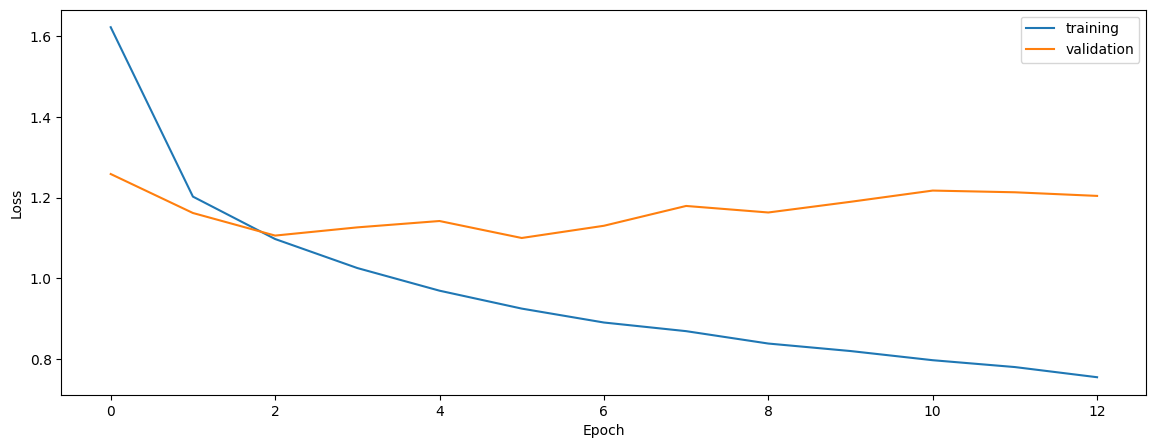

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6585837176120267
0.5851575340070637
0.5733479543795683


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6112089201877934
0.58101802757158
0.52016683772629


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.626927562524297
0.5918942349371478
0.5372769953051644


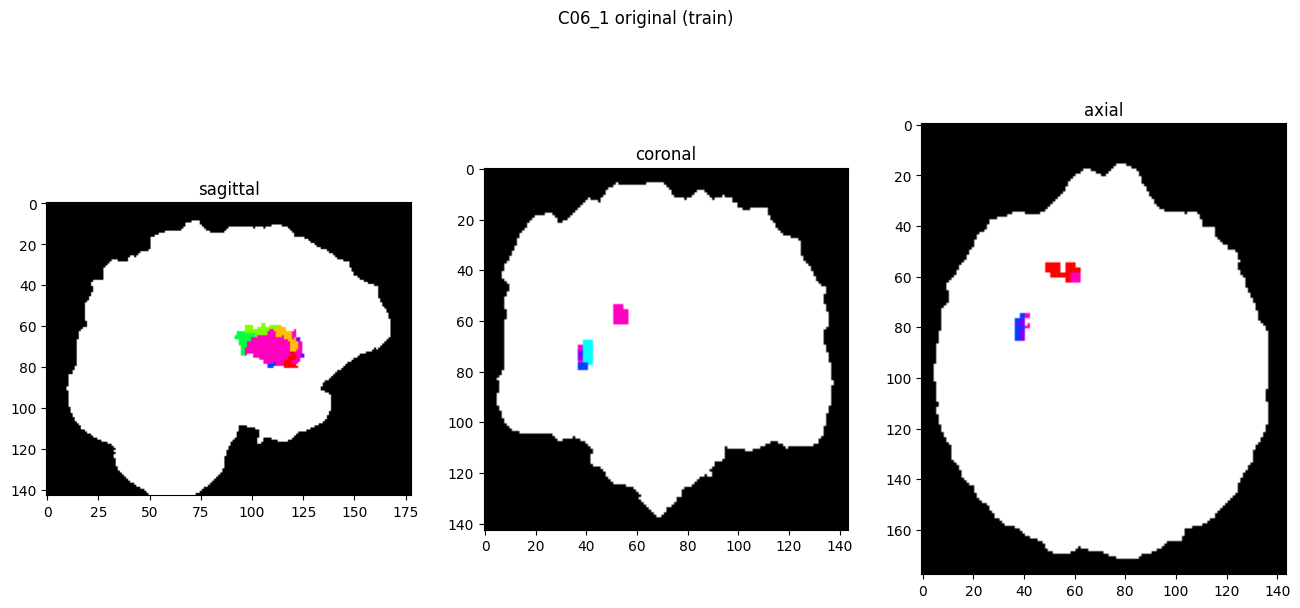

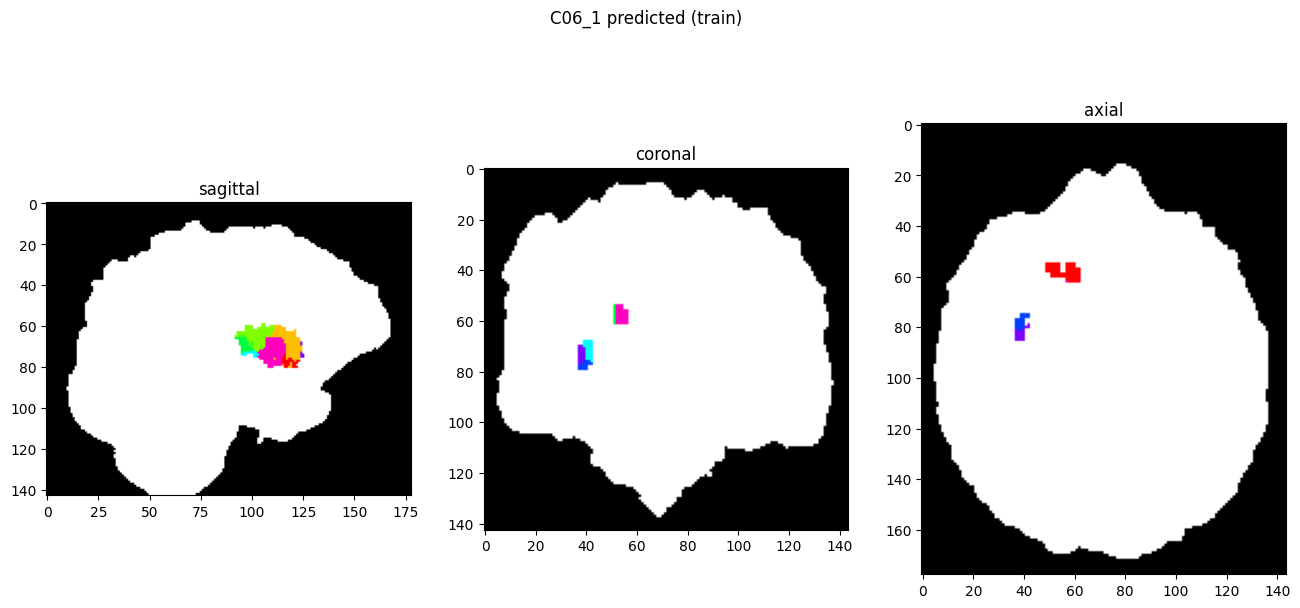

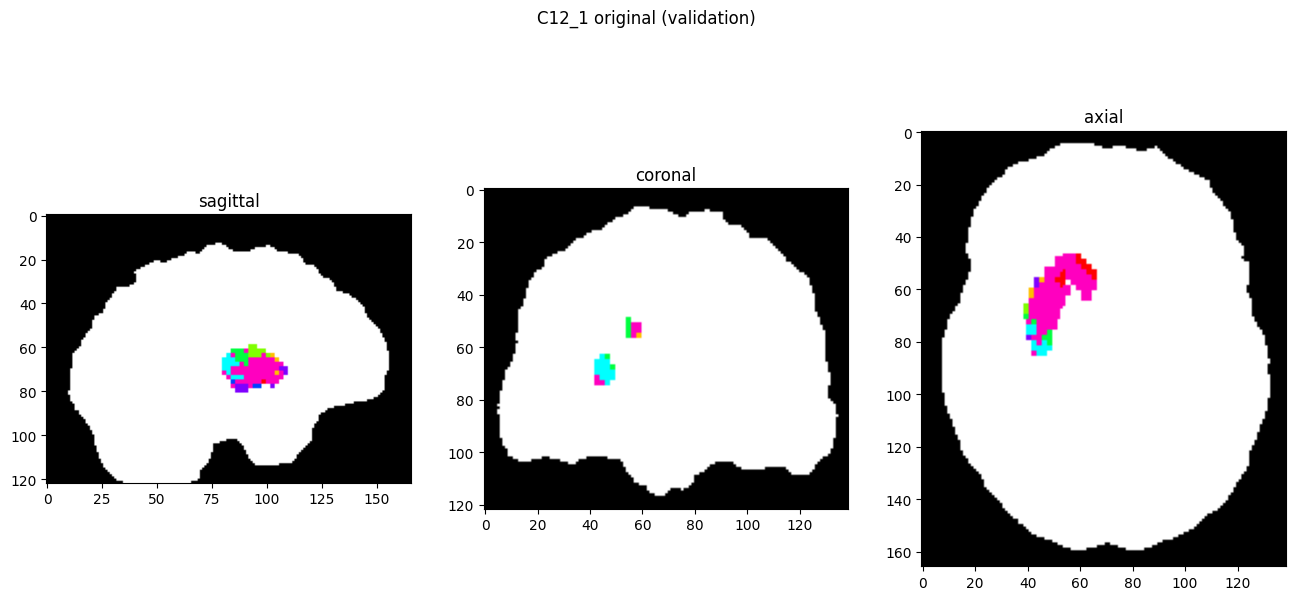

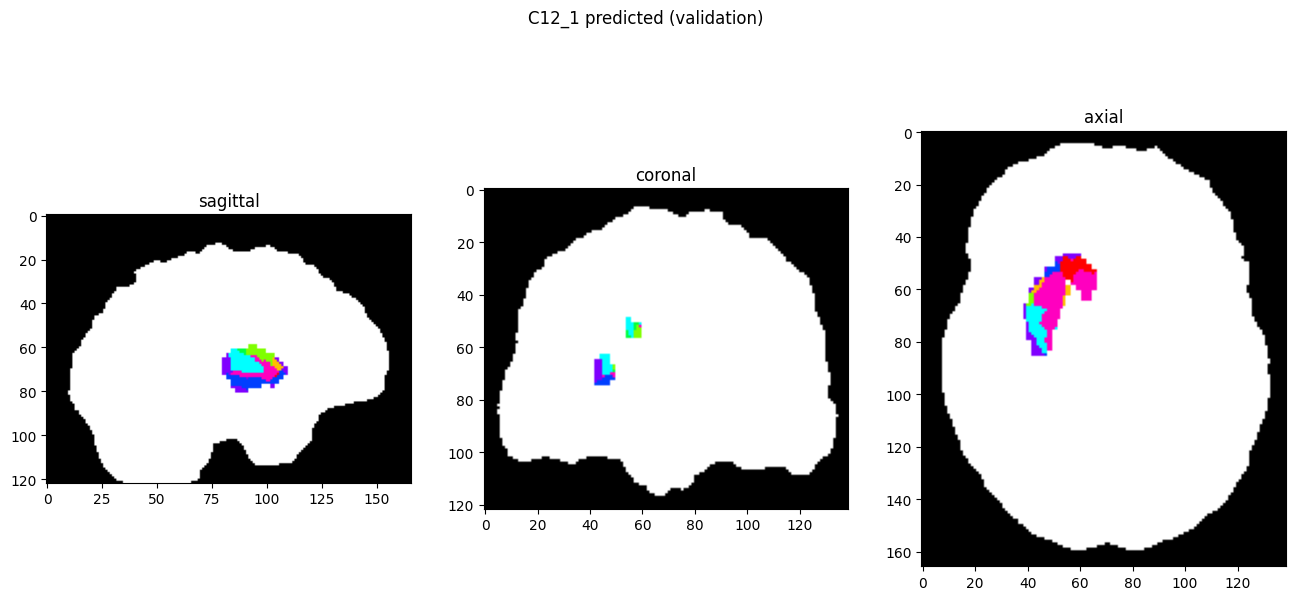

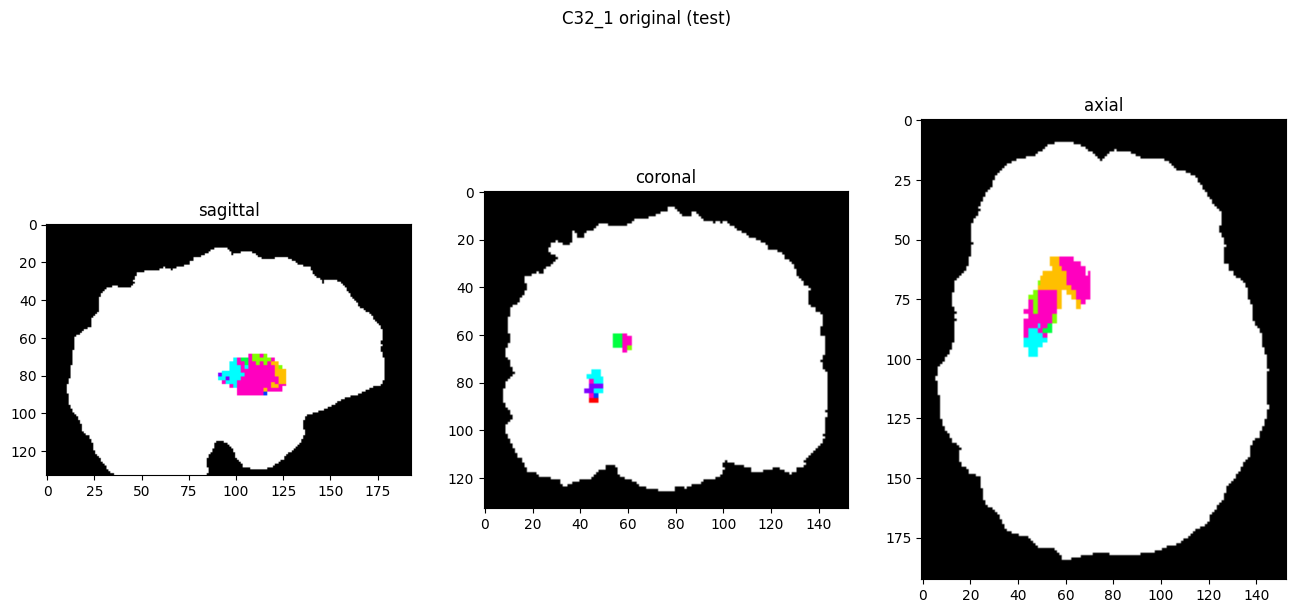

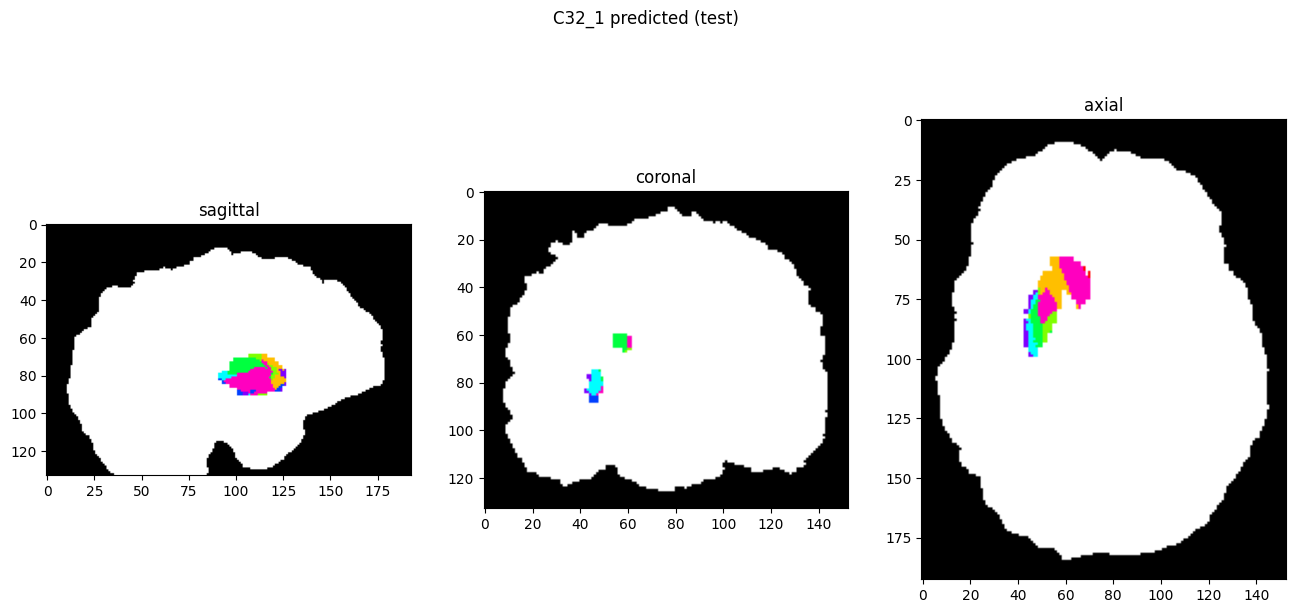

In [10]:
showResults(model, gen, threshold=0)